<a href="https://www.kaggle.com/code/markkoltman/bank-telemarketing-success-prediction?scriptVersionId=91910616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank Telemarketing Success Prediction

A Data-Driven Approach to Predict the Success of Bank Telemarketing. The goal is to predict if the client will subscribe a term deposit (variable y).

### The process includes:
- Data processing
- Defining and train a model using Keras
- Mapping from columns in the CSV to training features with the Keras preprocessing layers
- Evaluating the model using various metrics (including precision and recall)
- Trying common techniques for dealing with imbalanced data like:
 - Class weighting
 - Oversampling
- Saving and reloading the Keras model
- Performing inference on new data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# Data processing and exploration

In [2]:
df = pd.read_csv("../input/bank-marketing-data-set/bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


columns info:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

check for null and missing values:

In [4]:
print('num of null values:', df.isnull().sum().max())

num of null values: 0


According to the data description the variables job, education, default, housing and loan, contains 'unknown' values:

In [5]:
for col in ['job','education','default','housing','loan']:
    print(f'{col} unknown values:', df[col].value_counts().unknown)

job unknown values: 330
education unknown values: 1731
default unknown values: 8597
housing unknown values: 990
loan unknown values: 990


 I will drop these samples:

In [6]:
old_len = len(df.index)
df = df[(df.job != 'unknown') & (df.education != 'unknown') & (df.default != 'unknown') & \
        (df.housing != 'unknown') & (df.loan != 'unknown')]
new_len = len(df.index)
print(f'old num of rows: {old_len}')
print(f'new num of rows: {new_len}')

old num of rows: 41188
new num of rows: 30547


### Create a target variable


In [7]:
# set 0 for a client hasn't subscribed a term deposit
df['target'] = np.where(df['y']=='no', 0, 1)
df = df.drop(columns=['y'])

### Examine the class label imbalance

In [8]:
neg, pos = np.bincount(df['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 30547
    Positive: 3868 (12.66% of total)



This shows the small fraction of positive samples.

# Split the data into training, validation, and test sets

In [9]:
# Use a utility from sklearn to split and shuffle your dataset.
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

19549 training examples
4888 validation examples
6110 test examples


### Create an input pipeline using tf.data

In [10]:
# Function that converts each training, validation, and test set DataFrame
# into a tf.data.Dataset, then shuffles and batches the data.
def df_to_dataset(df, shuffle=True, batch_size=32):
    dataframe = df.copy()
    labels = dataframe.pop('target')
    dataframe = {key: tf.expand_dims(value,axis=1) for key, value in df.items()}    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

# Checking the format of the data the df_to_dataset function returns
train_ds = df_to_dataset(train, batch_size=5)
[(train_features, label_batch)] = train_ds.take(1)
print('All feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch)

All feature: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'target']
A batch of ages: tf.Tensor(
[[41]
 [32]
 [43]
 [47]
 [34]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


2022-04-02 11:37:34.992514: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Apply the Keras preprocessing layers
- *tf.keras.layers.Normalization*: Performs feature-wise normalization of input features.
- *tf.keras.layers.CategoryEncoding*: Turns integer categorical features into one-hot, multi-hot, or tf-idf dense representations.
- *tf.keras.layers.StringLookup*: Turns string categorical values into integer indices.

In [11]:
# Numerical columns - standardize the distribution of the data
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

# Test the get_normalization_layer function
age_col = train_features['age']
layer = get_normalization_layer('age', train_ds)
layer(age_col)

2022-04-02 11:37:35.461636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.19233698],
       [-0.67807364],
       [ 0.38576156],
       [ 0.7726107 ],
       [-0.48464903]], dtype=float32)>

In [12]:
# Categorical columns - one hot encoding
def get_category_encoding_layer(name, dataset, dtype):
    #strings into integer indices
    dtype == 'string'
    index = layers.StringLookup()
    #dataset of the feature only
    feature_ds = dataset.map(lambda x, y: x[name])    
    #learn the values and assign them a fixed integer index.
    index.adapt(feature_ds)
    #encode the integer indices.    
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

# Test the get_category_encoding_layer function
month_col = train_features['month']
print(month_col)
month_layer = get_category_encoding_layer(name='month',dataset=train_ds, dtype='string')
month_layer(month_col)

tf.Tensor(
[[b'jun']
 [b'may']
 [b'aug']
 [b'aug']
 [b'aug']], shape=(5, 1), dtype=string)


<tf.Tensor: shape=(5, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

### Preprocess selected features to train the model on

In [13]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Normalize the numerical features, and add them to one list of inputs called encoded_features
all_inputs = []
encoded_features = []

Numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',\
               'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for col in Numerical_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=col)
    normalization_layer = get_normalization_layer(col, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# turn the categorical values into integer indices, perform multi-hot encoding,
# and add the resulting feature inputs to encoded_features
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',\
                    'contact', 'month', 'day_of_week', 'poutcome']
for cols in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=cols, dtype='string')
    encoding_layer = get_category_encoding_layer(name=cols,dataset=train_ds,dtype='string')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

# Create, compile, and train the model
Define the model and metrics:
- False negatives and false positives are samples that were incorrectly classified.
- True negatives and true positives are samples that were correctly classified.
- Accuracy is the percentage of examples correctly classified.
- Precision is the percentage of predicted positives that were correctly classified.
- Recall is the percentage of actual positives that were correctly classified.
- AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
- AUPRC refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.


In [14]:
#define the metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Function that creates a simple neural network
def make_model(encoded_features=encoded_features, metrics=METRICS):
    # merge the list of feature inputs
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1)(x)
    output = tf.nn.sigmoid(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    return model

Visualize the connectivity graph

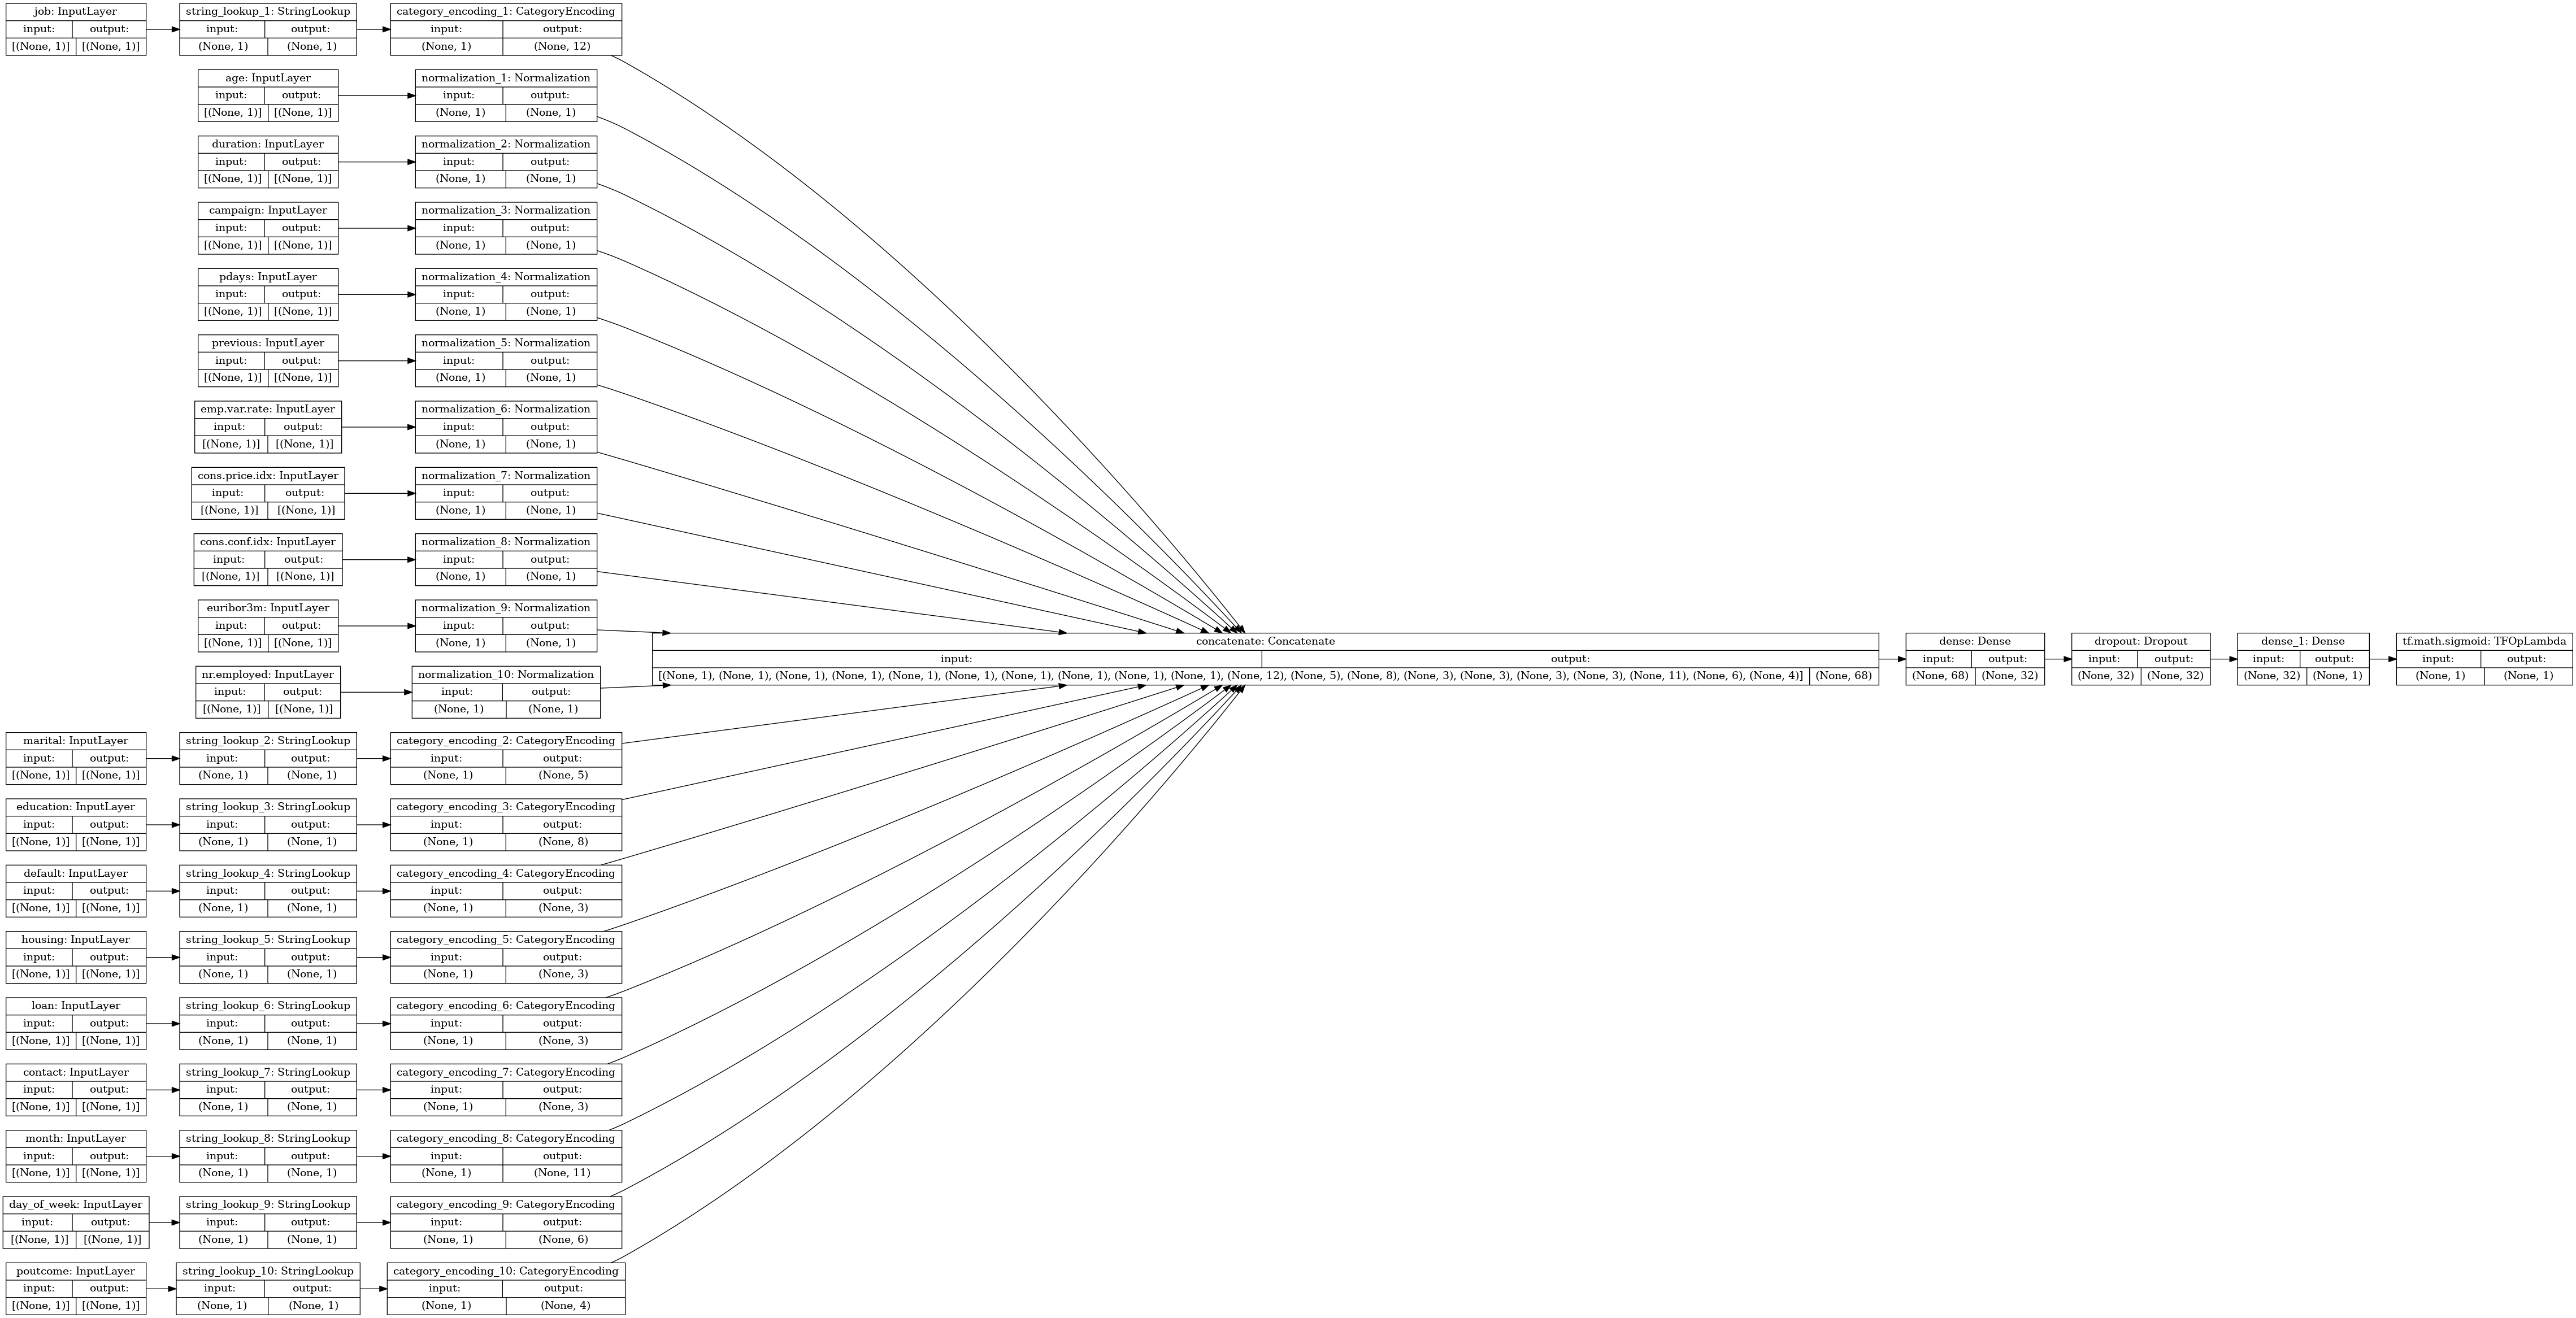

In [15]:
model = make_model()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the model

In [16]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


77/77 [==============================] - 5s 30ms/step - loss: 0.4173 - tp: 655.0000 - fp: 1388.0000 - tn: 15643.0000 - fn: 1863.0000 - accuracy: 0.8337 - precision: 0.3206 - recall: 0.2601 - auc: 0.6776 - prc: 0.2753 - val_loss: 0.2847 - val_tp: 142.0000 - val_fp: 62.0000 - val_tn: 4219.0000 - val_fn: 465.0000 - val_accuracy: 0.8922 - val_precision: 0.6961 - val_recall: 0.2339 - val_auc: 0.8415 - val_prc: 0.4881
Epoch 2/100
77/77 [==============================] - 1s 7ms/step - loss: 0.3062 - tp: 666.0000 - fp: 446.0000 - tn: 16585.0000 - fn: 1852.0000 - accuracy: 0.8824 - precision: 0.5989 - recall: 0.2645 - auc: 0.8163 - prc: 0.4471 - val_loss: 0.2481 - val_tp: 184.0000 - val_fp: 88.0000 - val_tn: 4193.0000 - val_fn: 423.0000 - val_accuracy: 0.8955 - val_precision: 0.6765 - val_recall: 0.3031 - val_auc: 0.9031 - val_prc: 0.5685
Epoch 3/100
77/77 [==============================] - 1s 8ms/step - loss: 0.2773 - tp: 844.0000 - fp: 492.0000 - tn: 16539.0000 - fn: 1674.0000 - accuracy: 0.8

### Check training history

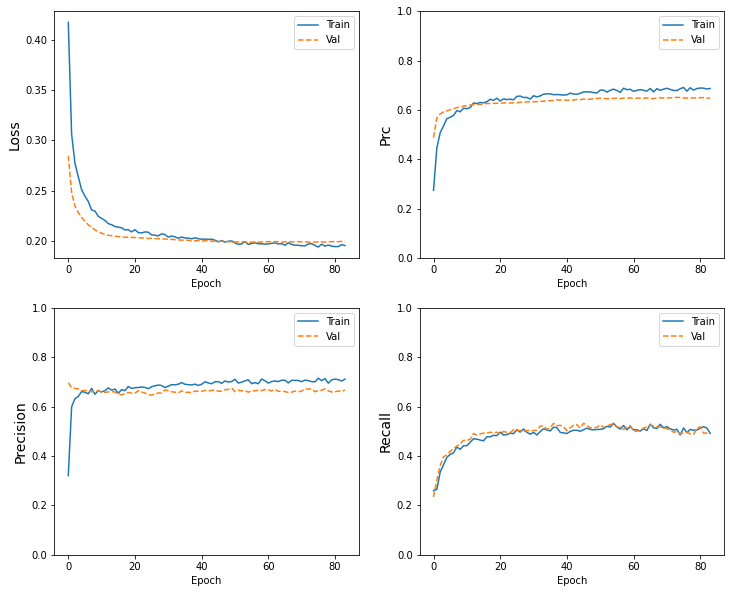

In [17]:
# Produce plots of the model's loss on the training and validation set (useful to check for overfitting),
# and other metrics created above
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    plt.figure(figsize=(12,10)) 
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch',fontsize=10)
        plt.ylabel(name, fontsize=14)
        if metric == 'loss':
            plt.ylim()
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

plot_metrics(history)

### Evaluate metrics
I will use a confusion matrix to summarize the actual vs. predicted labels.
- X axis - predicted label 
- Y axis - actual label

loss :  0.19693660736083984
tp :  361.0
fp :  202.0
tn :  5165.0
fn :  382.0
accuracy :  0.9044190049171448
precision :  0.6412078142166138
recall :  0.48586809635162354
auc :  0.9361248016357422
prc :  0.6377278566360474

Customers who have not deposited Detected  (True Negatives):  5165
Customers who have not deposited Incorrectly Detected (False Positives):  202
Customers who have deposited Missed (False Negatives):  382
Customers who have deposited Detected (True Positives):  361
Total customers who have deposited:  743


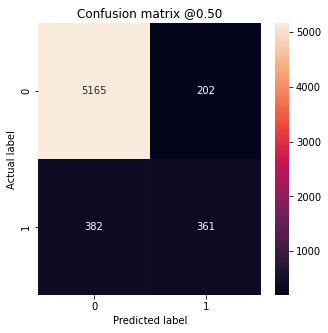

In [18]:
test_predictions_baseline = model.predict(test_ds)

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Customers who have not deposited Detected  (True Negatives): ', cm[0][0])
    print('Customers who have not deposited Incorrectly Detected (False Positives): ', cm[0][1])
    print('Customers who have deposited Missed (False Negatives): ', cm[1][0])
    print('Customers who have deposited Detected (True Positives): ', cm[1][1])
    print('Total customers who have deposited: ', np.sum(cm[1]))

baseline_results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test.target, test_predictions_baseline)

The matrix shows that we have relatively few false positives, meaning that there were relatively few unsuccessful telemarketing calls. However, we would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives may cause for successful calls not to be executed for a client who will subscribe a term deposit (because they have been classified as unsuccessful), whereas false positives may only cause an unsuccessful calls to happen.

A false negative may have a financial cost, while a false positive may decrease user happiness.

### Plot the ROC
This plot is useful because it shows, the range of performance the model can reach just by tuning the output threshold.

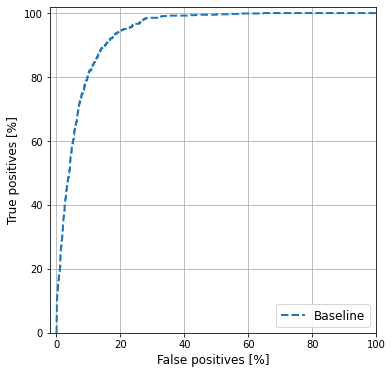

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]',fontsize=12)
    plt.ylabel('True positives [%]',fontsize=12)
    plt.xlim([-2,100])
    plt.ylim([0,102])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plt.figure(figsize=(8,6)) 
plot_roc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right', fontsize='large');

### Plot the AUPRC

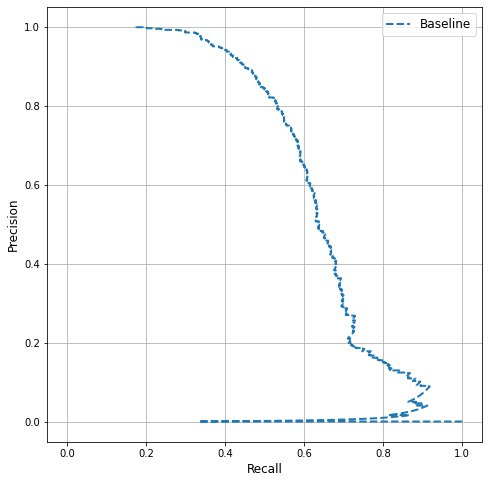

In [20]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plt.figure(figsize=(8,8)) 
plot_prc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='upper right', fontsize='large')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of our problem.

# Class weights

The goal is to identify a client which will subscribe a term deposit, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. I will do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [21]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 3.95


### Train a model with class weights
Now try re-training and evaluating the model with class weights to see how that affects the predictions.

In [22]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds,
    class_weight=class_weight)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


77/77 [==============================] - 6s 32ms/step - loss: 0.6388 - tp: 1742.0000 - fp: 4746.0000 - tn: 17652.0000 - fn: 1519.0000 - accuracy: 0.7558 - precision: 0.2685 - recall: 0.5342 - auc: 0.7420 - prc: 0.3188 - val_loss: 0.4920 - val_tp: 437.0000 - val_fp: 899.0000 - val_tn: 3382.0000 - val_fn: 170.0000 - val_accuracy: 0.7813 - val_precision: 0.3271 - val_recall: 0.7199 - val_auc: 0.8547 - val_prc: 0.4543
Epoch 2/100
77/77 [==============================] - 1s 10ms/step - loss: 0.4961 - tp: 1838.0000 - fp: 3496.0000 - tn: 13535.0000 - fn: 680.0000 - accuracy: 0.7864 - precision: 0.3446 - recall: 0.7299 - auc: 0.8495 - prc: 0.4436 - val_loss: 0.4114 - val_tp: 492.0000 - val_fp: 760.0000 - val_tn: 3521.0000 - val_fn: 115.0000 - val_accuracy: 0.8210 - val_precision: 0.3930 - val_recall: 0.8105 - val_auc: 0.8999 - val_prc: 0.5518
Epoch 3/100
77/77 [==============================] - 1s 10ms/step - loss: 0.4413 - tp: 2002.0000 - fp: 3216.0000 - tn: 13815.0000 - fn: 516.0000 - accura

### Check training history

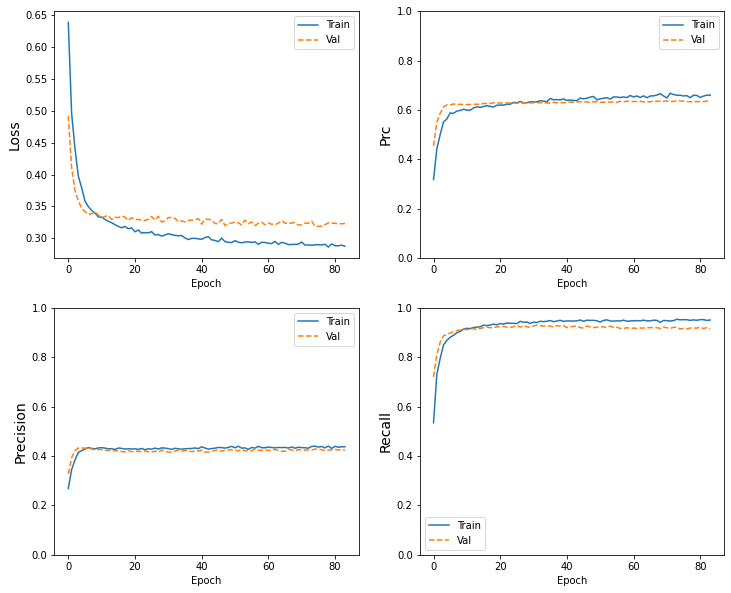

In [23]:
plot_metrics(weighted_history)

### Evaluate metrics

loss :  0.3361157476902008
tp :  693.0
fp :  1012.0
tn :  4355.0
fn :  50.0
accuracy :  0.8261865973472595
precision :  0.40645161271095276
recall :  0.9327052235603333
auc :  0.9344314336776733
prc :  0.6248438954353333

Customers who have not deposited Detected  (True Negatives):  4355
Customers who have not deposited Incorrectly Detected (False Positives):  1012
Customers who have deposited Missed (False Negatives):  50
Customers who have deposited Detected (True Positives):  693
Total customers who have deposited:  743


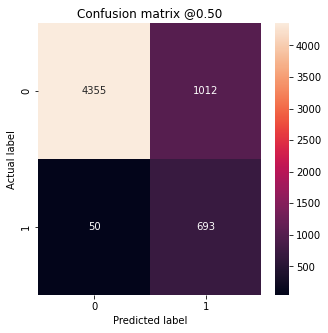

In [24]:
train_predictions_weighted = weighted_model.predict(train_ds)
test_predictions_weighted = weighted_model.predict(test_ds)

weighted_results = weighted_model.evaluate(test_ds, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test.target, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more successful calls). Of course, there is a cost to both types of error (you wouldn't want to bug users by calling many clients which does not seek to deposit).

### Plot the ROC

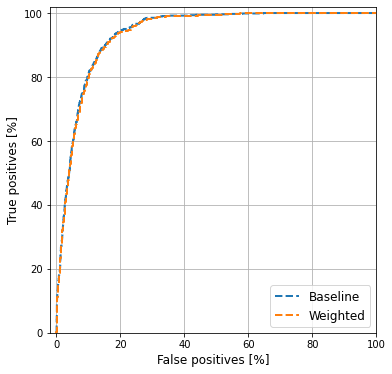

In [25]:
plt.figure(figsize=(8,6)) 
plot_roc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Weighted", test.target, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right', fontsize='large')

### Plot the AUPRC

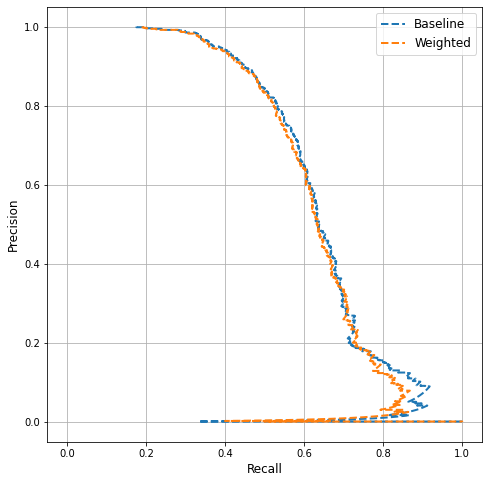

In [26]:
plt.figure(figsize=(8,8)) 
plot_prc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plot_prc("Weighted", test.target, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='upper right', fontsize='large')

# Oversampling
### Oversample the minority class
A related approach would be to resample the dataset by oversampling the minority class.

In [27]:
pos_df = train[train['target']==1]
neg_df = train[train['target']==0]

# Balance the dataset by choosing the right number of random indices from the positive examples
ids = pos_df.index.values
choices = np.random.choice(ids, len(neg_df))
res_pos_df = pos_df.loc[choices]
print(f"old pos_samples: {pos_df.shape}")
print(f"new pos_samples: {res_pos_df.shape}")

old pos_samples: (2518, 21)
new pos_samples: (17031, 21)


In [28]:
resampled_df = pd.concat([res_pos_df,neg_df])
print(f"new total samples: {resampled_df.shape}")

resampled_df = sklearn.utils.shuffle(resampled_df)

batch_size = 2048
resampled_ds = df_to_dataset(resampled_df, batch_size=batch_size)

new total samples: (34062, 21)


### Re-train on the oversampled data

In [29]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


17/17 [==============================] - 5s 159ms/step - loss: 0.6091 - tp: 12119.0000 - fp: 6919.0000 - tn: 15479.0000 - fn: 5655.0000 - accuracy: 0.6870 - precision: 0.6366 - recall: 0.6818 - auc: 0.7632 - prc: 0.7080 - val_loss: 0.5559 - val_tp: 492.0000 - val_fp: 770.0000 - val_tn: 3511.0000 - val_fn: 115.0000 - val_accuracy: 0.8189 - val_precision: 0.3899 - val_recall: 0.8105 - val_auc: 0.8847 - val_prc: 0.5164
Epoch 2/100
17/17 [==============================] - 1s 54ms/step - loss: 0.5389 - tp: 12190.0000 - fp: 4000.0000 - tn: 13031.0000 - fn: 4841.0000 - accuracy: 0.7404 - precision: 0.7529 - recall: 0.7158 - auc: 0.8170 - prc: 0.8085 - val_loss: 0.4955 - val_tp: 499.0000 - val_fp: 792.0000 - val_tn: 3489.0000 - val_fn: 108.0000 - val_accuracy: 0.8159 - val_precision: 0.3865 - val_recall: 0.8221 - val_auc: 0.8930 - val_prc: 0.5277
Epoch 3/100
17/17 [==============================] - 1s 54ms/step - loss: 0.4958 - tp: 12720.0000 - fp: 3558.0000 - tn: 13473.0000 - fn: 4311.0000 - 

### Re-check training history

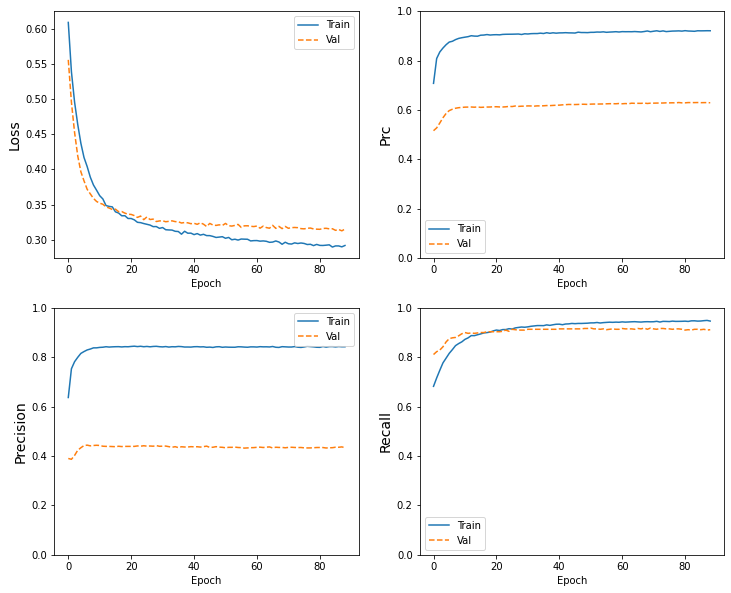

In [30]:
plot_metrics(resampled_history)

### Evaluate metrics

loss :  0.32322755455970764
tp :  678.0
fp :  933.0
tn :  4434.0
fn :  65.0
accuracy :  0.8366612195968628
precision :  0.42085662484169006
recall :  0.9125168323516846
auc :  0.934597909450531
prc :  0.6157755255699158

Customers who have not deposited Detected  (True Negatives):  4434
Customers who have not deposited Incorrectly Detected (False Positives):  933
Customers who have deposited Missed (False Negatives):  65
Customers who have deposited Detected (True Positives):  678
Total customers who have deposited:  743


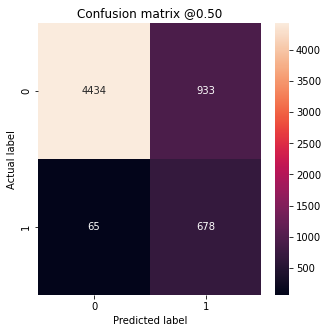

In [31]:
train_predictions_resampled = resampled_model.predict(resampled_ds)
test_predictions_resampled = resampled_model.predict(test_ds)

resampled_results = resampled_model.evaluate(test_ds, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test.target, test_predictions_resampled)

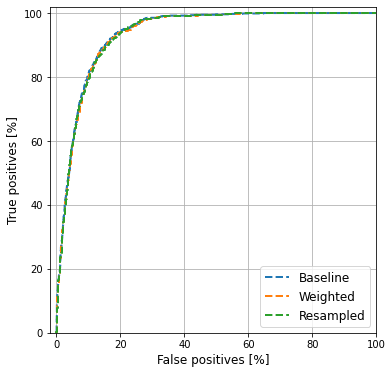

In [32]:
plt.figure(figsize=(8,6)) 
plot_roc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Weighted", test.target, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Resampled", test.target, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right', fontsize='large')

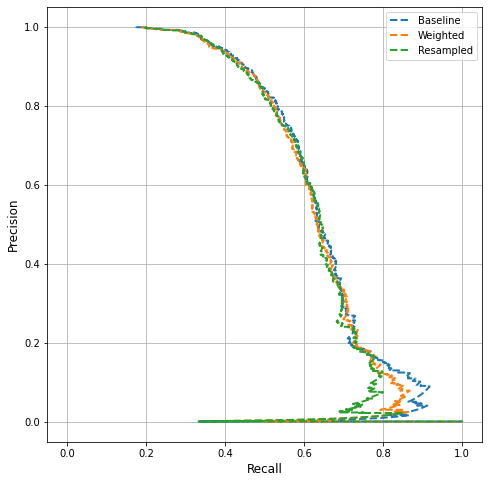

In [33]:
plt.figure(figsize=(8,8)) 
plot_prc("Baseline", test.target, test_predictions_baseline, color=colors[0], linestyle='--')
plot_prc("Weighted", test.target, test_predictions_weighted, color=colors[1], linestyle='--')
plot_prc("Resampled", test.target, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='upper right')

# Perform inference

The model I have developed can now classify a row from a CSV file directly after I've included the preprocessing layers inside the model itself.

In [34]:
# I will select one sample from the data as the "new data" so I can know the real label
df[df.index==41183]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [35]:
# Save and reload the Keras model
weighted_model.save('Bank_Telemarketing_Success_classifier')
reloaded_model = tf.keras.models.load_model('Bank_Telemarketing_Success_classifier')

# Get a prediction for a new sample
sample = {
    'age': 73,
    'job': 'retired',
    'marital': 'married',
    'education': 'professional.course',
    'default': 'no',
    'housing': 'yes',
    'loan': 'no',
    'contact': 'cellular',
    'month': 'nov',
    'day_of_week': 'fri',
    'duration': 334,
    'campaign': 1,
    'pdays': 999,
    'previous': 0,
    'poutcome': 'nonexistent',
    'emp.var.rate': -1.1,
    'cons.price.idx': 94.76,
    'cons.conf.idx': -50.8,
    'euribor3m': 1.028,
    'nr.employed': 4963.6,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
prob = reloaded_model.predict(input_dict)

print("This particular client had a %.1f percent probability of subscribe a term deposit." % (100 * prob))


2022-04-02 11:43:09.038474: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


This particular client had a 92.9 percent probability of subscribe a term deposit.
